# 1. `Authentication`

*** 1.1 Configure GPU  ***

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14088054931046630709, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 790650624432384949
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4390054040111700921
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 659911585175067633
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

*** 1.2 Authenticate to drive ***

In [0]:
from google.colab import drive     
drive.mount('/content/drive')

# 2. `Prepare Data`

```
Time series data was collected from the 18 experiments with a sampling rate of 100 ms and are separately reported in files experiment_01.csv to experiment_18.csv. Each file has measurements from the 4 motors in the CNC (X, Y, Z axes and spindle). 

The experiments were divided as train and test. Train dataset has 21254 data, and test dataset has 4032 data. In the train dataset, there is 11333 worn, and 9933 unworn!
```

*** 2.1 Import Required Libraries ***

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

*** 2.2 Read and Show Data ***

In [0]:
data_path = 'drive/My Drive/data/ai_project/'

In [0]:
# select experiments for create train and test data

train_data_exp_numbers = ['02', '03', '06', '07', '08', '09', '10', '11', '12',
                          '13', '14', '17', '18']
test_data_exp_numbers = ['01', '04', '05', '15', '16']

In [0]:
# create train and test data from experiments by defined exp above

train = []
test = []
results = pd.read_csv(data_path + "train.csv")
for i in range(1,19):
    exp_no = '0' + str(i) if i < 10 else str(i)
    experiment = pd.read_csv(data_path + "experiment_{}.csv".format(exp_no))
    
    row = results[results['No'] == i]
    label = 1 if row.iloc[0]['tool_condition'] == 'worn' else 0
    experiment['exp_no'] = i
    experiment['target'] = label
    
    if exp_no in train_data_exp_numbers:
      train.append(experiment)
    elif exp_no in test_data_exp_numbers:
      test.append(experiment)  

In [0]:
# create pandas dataframe from splitted train list

train_df = pd.concat(train, ignore_index = True)
train_df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,exp_no,target
0,198.0,0.0,0.0,198.0,0.0,0.0,-0.284,2.790000e-19,329.0,0.0,...,332.0,0.0,0.000000e+00,12.0,1.0,2.0,50.0,Prep,2,0
1,198.0,0.0,0.0,198.0,0.0,0.0,-0.284,2.790000e-19,329.0,0.0,...,332.0,0.0,0.000000e+00,12.0,0.0,0.0,50.0,Prep,2,0
2,198.0,0.0,0.0,198.0,0.0,0.0,1.170,2.780000e-19,325.0,0.0,...,324.0,0.0,-8.590000e-07,12.0,0.0,0.0,50.0,Prep,2,0
3,198.0,0.0,0.0,198.0,0.0,0.0,-0.230,2.790000e-19,329.0,0.0,...,332.0,0.0,-6.290000e-06,12.0,4.0,0.0,50.0,Prep,2,0
4,198.0,0.0,0.0,198.0,0.0,0.0,-0.230,2.790000e-19,329.0,0.0,...,332.0,0.0,-6.290000e-06,12.0,0.0,0.0,50.0,Prep,2,0


In [0]:
# details of training data

train_df.describe()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,exp_no,target
count,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,2.125400e+04,21254.000000,21254.000000,...,21254.000000,21254.000000,21254.000000,21254.000000,21254.0,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000
mean,157.757410,-0.294215,-0.181079,157.756187,-0.289564,0.157908,-0.463216,6.697292e-02,326.878564,7.900005,...,0.692755,322.562435,88.680213,0.132032,12.0,1.004093,49.569681,15.662275,11.089066,0.532841
std,18.336972,5.322638,92.264608,18.337343,5.333335,70.110158,4.227688,3.572546e-02,1.415503,7.277098,...,0.418000,4.191599,50.835815,0.078149,0.0,0.380724,43.813635,19.317784,4.866942,0.498932
min,141.000000,-20.400000,-1280.000000,141.000000,-20.000000,-1000.000000,-23.200000,2.780000e-19,320.000000,0.000000,...,0.000000,290.000000,0.000000,-0.002840,12.0,0.000000,0.000000,3.000000,2.000000,0.000000
25%,144.000000,-2.130000,-31.300000,144.000000,-2.127500,0.000000,-3.960000,4.520000e-02,327.000000,2.880000,...,0.698000,320.000000,110.000000,0.132000,12.0,1.000000,2.000000,3.000000,8.000000,0.000000
50%,152.000000,0.000000,0.000000,152.000000,0.000000,0.000000,-0.638000,6.750000e-02,327.000000,7.305000,...,0.865000,322.000000,117.000000,0.166000,12.0,1.000000,43.000000,3.000000,12.000000,1.000000
75%,161.000000,0.275000,31.300000,161.000000,0.199750,0.000000,3.290000,9.090000e-02,327.000000,9.960000,...,0.956000,324.000000,119.000000,0.184000,12.0,1.000000,87.000000,20.000000,14.000000,1.000000
max,198.000000,50.300000,1440.000000,198.000000,50.000000,1000.000000,25.800000,3.800000e-01,330.000000,75.400000,...,3.150000,332.000000,130.000000,0.552000,12.0,4.000000,135.000000,50.000000,18.000000,1.000000


In [0]:
# create pandas dataframe from splitted test list

test_df = pd.concat(test, ignore_index = True)
test_df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,exp_no,target
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,1,0
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,1,0
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,1,0
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,1,0
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,1,0


In [0]:
# details of testing data

test_df.describe()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,exp_no,target
count,4032.000000,4032.000000,4032.000000,4032.000000,4032.000000,4032.000000,4032.000000,4.032000e+03,4032.000000,4032.000000,...,4.032000e+03,4032.000000,4032.000000,4032.000000,4032.0,4032.0,4032.000000,4032.000000,4032.000000,4032.000000
mean,165.876488,-0.259358,1.545685,165.874504,-0.248879,0.755606,-0.503969,6.106414e-02,327.300595,8.445214,...,5.456198e-01,323.955109,68.605574,0.103015,12.0,1.0,35.618056,21.179563,8.888889,0.491815
std,22.709946,7.173136,101.959417,22.710044,7.161152,84.501978,4.184341,4.278402e-02,1.629674,9.667088,...,4.878006e-01,4.622834,57.842908,0.089421,0.0,0.0,41.992562,20.531550,6.443777,0.499995
min,141.000000,-20.200000,-1230.000000,141.000000,-20.000000,-1000.000000,-23.400000,2.780000e-19,320.000000,0.000000,...,2.700000e-19,290.000000,0.000000,-0.002960,12.0,1.0,0.000000,6.000000,1.000000,0.000000
25%,147.000000,-0.950000,-18.800000,147.000000,-0.872750,0.000000,-3.590000,2.340000e-02,326.000000,1.500000,...,2.760000e-19,321.000000,0.000000,0.000000,12.0,1.0,0.000000,6.000000,1.000000,0.000000
50%,157.500000,0.000000,0.000000,157.000000,0.000000,0.000000,-0.780000,5.360000e-02,327.000000,5.390000,...,7.960000e-01,323.000000,115.000000,0.152000,12.0,1.0,18.000000,6.000000,5.000000,0.000000
75%,198.000000,0.100000,18.800000,198.000000,0.000000,0.000000,1.962500,9.332500e-02,329.000000,13.400000,...,9.320000e-01,329.000000,118.000000,0.179000,12.0,1.0,67.000000,50.000000,15.000000,1.000000
max,198.000000,50.700000,1280.000000,198.000000,50.000000,1000.000000,27.100000,3.800000e-01,331.000000,74.000000,...,3.160000e+00,330.000000,130.000000,0.569000,12.0,1.0,132.000000,50.000000,16.000000,1.000000


# 3. `Exploratory Data Analysis`

```
Explore data for analyze and explore characteristic of features.

Firstly, look standard deviation of features, and examine distribution of features. If SD of any feature is zero, remove this feature. Because, each value of this features is zero or same. Also, remove position values, because position values does not effect to wear!

Find correlation of features with target(worn or unworn). Because, low correlated features with target less effect than high correlated features with target, and then will be removed. Then, correlations will be find between features which has high correlation features. If the finded correlation values is greather than 0.8, this may hurt the performance of some ML algorithms.

Lastly, plot sensor values to learn characteristic of sensors. 

```

In [0]:
# define input features for find unnecessary, low and high correlated features.

input_features = ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity',
       'X1_CommandAcceleration', 'X1_CurrentFeedback', 'X1_DCBusVoltage',
       'X1_OutputCurrent', 'X1_OutputVoltage', 'X1_OutputPower',
       'Y1_ActualPosition', 'Y1_ActualVelocity', 'Y1_ActualAcceleration',
       'Y1_CommandPosition', 'Y1_CommandVelocity',
       'Y1_CommandAcceleration', 'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
       'Y1_OutputCurrent', 'Y1_OutputVoltage', 'Y1_OutputPower',
       'Z1_ActualPosition', 'Z1_ActualVelocity', 'Z1_ActualAcceleration',
       'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration',
       'S1_CurrentFeedback', 'S1_DCBusVoltage', 'S1_OutputCurrent',
       'S1_OutputVoltage', 'S1_OutputPower', 'S1_SystemInertia',
       'M1_CURRENT_PROGRAM_NUMBER', 'M1_sequence_number',
       'M1_CURRENT_FEEDRATE']

*** 3.1 Find Standart Deviation of Features  ***

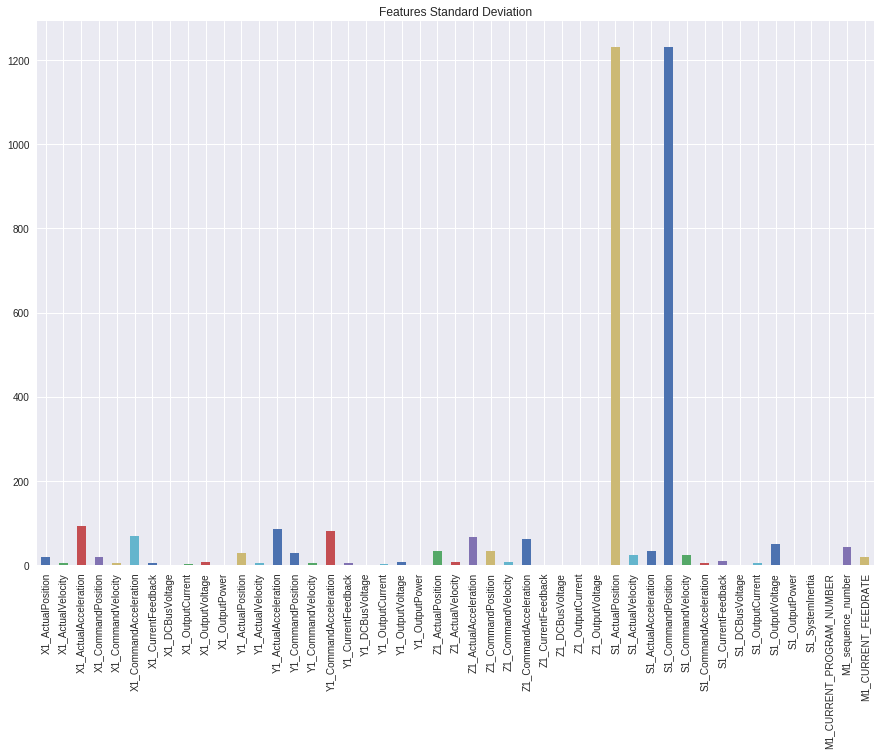

In [0]:
# standard deviation of input features, this may be used to look distribution
# of data.

train_df[input_features].std().plot(kind='bar', figsize=(15, 10), title="Features Standard Deviation")

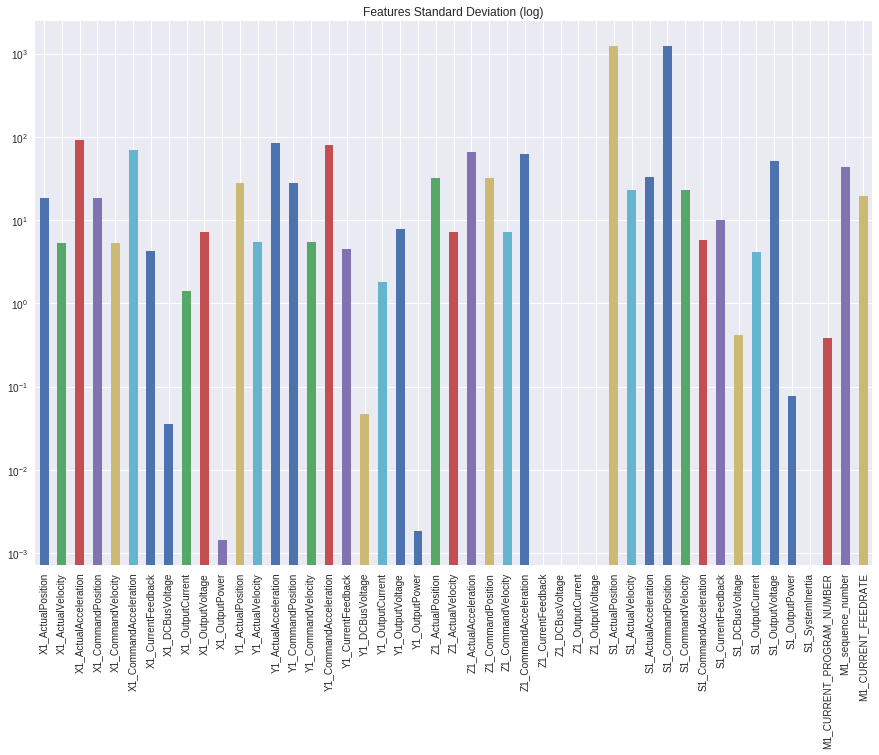

In [0]:
# standard deviation of input features with log(can be analyzed better),
# this may be used to look distribution of data. If any std value zero, 
# it means, all values of this features is zero or same

train_df[input_features].std().plot(kind='bar', figsize=(15, 10), logy = True, title="Features Standard Deviation (log)")

*** 3.2 Drop Unnecessary Features ***

In [0]:
# drop unnecessary data from training and testing data
# for example, positon values is unnecessary, 
# because position values does not give any information about wear!


train_df.drop(columns = ['X1_ActualPosition', 'X1_CommandPosition', 'Y1_ActualPosition',
                        'Y1_CommandPosition', 'Z1_ActualPosition', 'Z1_CommandPosition',
                        'S1_ActualPosition', 'S1_CommandPosition', 'M1_CURRENT_PROGRAM_NUMBER',
                        'M1_sequence_number', 'Machining_Process', 'Z1_CurrentFeedback', 
                        'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage', 
                        'S1_SystemInertia'], inplace = True)

test_df.drop(columns = ['X1_ActualPosition', 'X1_CommandPosition', 'Y1_ActualPosition',
                        'Y1_CommandPosition', 'Z1_ActualPosition', 'Z1_CommandPosition',
                        'S1_ActualPosition', 'S1_CommandPosition', 'M1_CURRENT_PROGRAM_NUMBER',
                        'M1_sequence_number', 'Machining_Process', 'Z1_CurrentFeedback', 
                        'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage', 
                        'S1_SystemInertia'], inplace = True)

In [0]:
# assign remaining features after removing unnecessary features!

input_features = ['X1_ActualVelocity', 'X1_ActualAcceleration', 'X1_CommandVelocity',
       'X1_CommandAcceleration', 'X1_CurrentFeedback', 'X1_DCBusVoltage',
       'X1_OutputCurrent', 'X1_OutputVoltage', 'X1_OutputPower',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandVelocity',
       'Y1_CommandAcceleration', 'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
       'Y1_OutputCurrent', 'Y1_OutputVoltage', 'Y1_OutputPower',
       'Z1_ActualVelocity', 'Z1_ActualAcceleration', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'S1_ActualVelocity',
       'S1_ActualAcceleration', 'S1_CommandVelocity',
       'S1_CommandAcceleration', 'S1_CurrentFeedback', 'S1_DCBusVoltage',
       'S1_OutputCurrent', 'S1_OutputVoltage', 'S1_OutputPower',
       'M1_CURRENT_FEEDRATE']

*** 3.3 Find High and Low Correlations of Features with 'Target' ***

In [0]:
# find high and low correlations of features with target(worn or unworn)
# because, high and low correlations will be used in machine learning
# algorithms for more accuracy!

#  1: high correlation that positive direction
#  0: no correlation between feature and target
# -1: high correlation that negative direction

train_df[input_features].corrwith(train_df['target']).sort_values(ascending=False)

X1_DCBusVoltage           0.110333
X1_OutputVoltage          0.102797
Y1_OutputVoltage          0.086721
X1_OutputPower            0.084378
Y1_OutputPower            0.073279
Y1_DCBusVoltage           0.070769
S1_CurrentFeedback        0.028117
M1_CURRENT_FEEDRATE       0.028103
S1_DCBusVoltage           0.026408
S1_ActualVelocity         0.025546
S1_OutputPower            0.024930
S1_OutputVoltage          0.023637
S1_CommandVelocity        0.023372
X1_ActualAcceleration     0.011206
S1_CommandAcceleration    0.009048
Y1_CommandAcceleration    0.007331
Y1_ActualAcceleration     0.002781
Z1_CommandAcceleration    0.002681
Z1_ActualAcceleration     0.000072
Y1_CurrentFeedback       -0.001783
X1_CommandAcceleration   -0.008565
X1_ActualVelocity        -0.010035
Z1_CommandVelocity       -0.010210
Z1_ActualVelocity        -0.010364
X1_CommandVelocity       -0.011079
S1_ActualAcceleration    -0.011519
Y1_CommandVelocity       -0.015588
Y1_ActualVelocity        -0.016536
X1_CurrentFeedback  

In [0]:
# if correlation of feature with target between 0.01 and -0.01, 
# features which has these values have assign as low correlation!

# Note: Selected low correlation features may be changed by developer!

low_corr_features = ['S1_CommandAcceleration', 'Y1_CommandAcceleration',
                    'Y1_ActualAcceleration', 'Z1_CommandAcceleration', 
                     'Z1_ActualAcceleration', 'Y1_CurrentFeedback',
                    'X1_CommandAcceleration']

train_df[low_corr_features].describe()

,S1_CommandAcceleration,Y1_CommandAcceleration,Y1_ActualAcceleration,Z1_CommandAcceleration,Z1_ActualAcceleration,Y1_CurrentFeedback,X1_CommandAcceleration
count,2.125400e+04,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000
mean,3.269973e-01,1.571050,0.330192,0.088939,-0.190369,-0.051204,0.157908
std,5.698833e+00,80.967479,85.122992,61.498491,65.541811,4.454880,70.110158
min,-9.540000e-07,-1000.000000,-1260.000000,-1000.000000,-1260.000000,-27.800000,-1000.000000
25%,0.000000e+00,0.000000,-18.800000,0.000000,-6.250000,-3.260000,0.000000
50%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.216000,0.000000
75%,0.000000e+00,0.000000,18.800000,0.000000,6.250000,3.027500,0.000000
max,1.000000e+02,1000.000000,1460.000000,1000.000000,1230.000000,30.700000,1000.000000


In [0]:
# drop low correlations from train and test datasets

train_df.drop(columns = low_corr_features, inplace = True)
test_df.drop(columns = low_corr_features, inplace = True)

In [0]:
high_corr_features = ['X1_DCBusVoltage', 'X1_OutputVoltage',
                     'Y1_OutputVoltage', 'X1_OutputPower',
                     'Y1_OutputPower', 'Y1_DCBusVoltage',
                     'S1_CurrentFeedback', 'M1_CURRENT_FEEDRATE',
                     'S1_DCBusVoltage', 'S1_ActualVelocity',
                     'S1_OutputPower', 'S1_OutputVoltage',
                     'S1_CommandVelocity', 'X1_ActualAcceleration',
                     'X1_ActualVelocity', 'Z1_CommandVelocity',
                     'Z1_ActualVelocity', 'X1_CommandVelocity',
                     'S1_ActualAcceleration', 'Y1_CommandVelocity',
                     'Y1_ActualVelocity', 'X1_CurrentFeedback',
                     'S1_OutputCurrent', 'X1_OutputCurrent',
                     'Y1_OutputCurrent']

train_df[high_corr_features].describe()

,X1_DCBusVoltage,X1_OutputVoltage,Y1_OutputVoltage,X1_OutputPower,Y1_OutputPower,Y1_DCBusVoltage,S1_CurrentFeedback,M1_CURRENT_FEEDRATE,S1_DCBusVoltage,S1_ActualVelocity,...,Z1_CommandVelocity,Z1_ActualVelocity,X1_CommandVelocity,S1_ActualAcceleration,Y1_CommandVelocity,Y1_ActualVelocity,X1_CurrentFeedback,S1_OutputCurrent,X1_OutputCurrent,Y1_OutputCurrent
count,2.125400e+04,21254.000000,21254.000000,21254.000000,21254.000000,2.125400e+04,21254.000000,21254.000000,21254.000000,21254.000000,...,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000,21254.000000
mean,6.697292e-02,7.900005,6.904596,0.000571,0.000565,6.471636e-02,15.722588,15.662275,0.692755,40.394234,...,-0.329475,-0.329895,-0.289564,0.154415,-0.416374,-0.428358,-0.463216,322.562435,326.878564,325.848358
std,3.572546e-02,7.277098,7.897493,0.001424,0.001843,4.657656e-02,9.935878,19.317784,0.418000,22.714565,...,7.159616,7.160732,5.333335,32.763852,5.425332,5.428725,4.227688,4.191599,1.415503,1.826681
min,2.780000e-19,0.000000,0.000000,-0.004740,-0.004920,2.680000e-19,-8.280000,3.000000,0.000000,-0.061300,...,-50.000000,-51.500000,-20.000000,-150.000000,-32.400000,-32.800000,-23.200000,290.000000,320.000000,319.000000
25%,4.520000e-02,2.880000,1.890000,0.000000,0.000000,2.270000e-02,12.400000,3.000000,0.698000,53.100000,...,0.000000,-0.025000,-2.127500,-17.600000,0.000000,-0.075000,-3.960000,320.000000,327.000000,325.000000
50%,6.750000e-02,7.305000,5.240000,0.000211,0.000006,5.990000e-02,19.000000,3.000000,0.865000,53.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.638000,322.000000,327.000000,326.000000
75%,9.090000e-02,9.960000,9.470000,0.000554,0.000488,9.590000e-02,22.500000,20.000000,0.956000,53.400000,...,0.000000,0.000000,0.199750,19.300000,0.000000,0.100000,3.290000,324.000000,327.000000,326.000000
max,3.800000e-01,75.400000,72.700000,0.029100,0.027400,4.300000e-01,74.000000,50.000000,3.150000,53.800000,...,50.000000,50.400000,50.000000,139.000000,50.000000,49.700000,25.800000,332.000000,330.000000,333.000000


*** 3.4 Find Correlation of Features Which has High Correlated with Target ***

In [0]:
# add 'target' feature to high correlation features!

corr_features = high_corr_features + ['target']

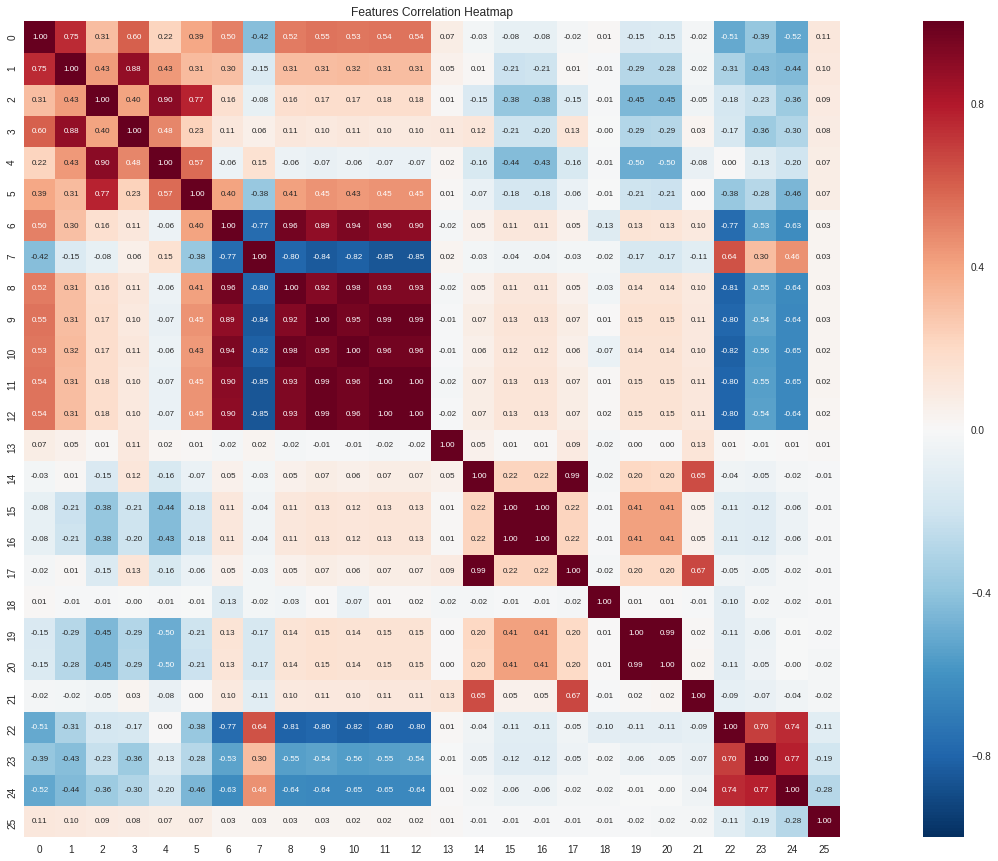

In [0]:

# find correlations between each feature
# colors close to red and blue(close to 1 or -1) means one features has high correlation with 
# another feature 

# if correlation of feature is greater than 0.8, some machine learning
# algorithms can show low performance!

corr_coef = np.corrcoef(train_df[corr_features].values.T)
sns.set(font_scale = 1.0)
fig = plt.figure(figsize = (30, 15))
hm = sns.heatmap(corr_coef, cbar = True, annot = True, square = True,
                 fmt = '.2f', annot_kws = {'size': 8})
plt.title('Features Correlation Heatmap')
plt.show()

In [0]:
sns.reset_orig()

In [0]:
high_corr_features = ['X1_DCBusVoltage', 'X1_OutputVoltage',
                     'Y1_OutputVoltage', 'X1_OutputPower',
                     'Y1_OutputPower', 'Y1_DCBusVoltage',
                     'M1_CURRENT_FEEDRATE',
                     'S1_DCBusVoltage', 'S1_ActualVelocity',
                     'S1_OutputPower', 'S1_OutputVoltage',
                     'X1_ActualAcceleration',
                     'X1_ActualVelocity',
                     'Z1_ActualVelocity',
                     'S1_ActualAcceleration',
                     'Y1_ActualVelocity', 'X1_CurrentFeedback',
                     'S1_OutputCurrent', 'X1_OutputCurrent',
                     'Y1_OutputCurrent']

train_df.drop(columns = ['S1_CurrentFeedback', 'S1_CommandVelocity',
                      'Z1_CommandVelocity', 'X1_CommandVelocity',
                     'Y1_CommandVelocity'], inplace = True)

test_df.drop(columns = ['S1_CurrentFeedback', 'S1_CommandVelocity',
                      'Z1_CommandVelocity', 'X1_CommandVelocity',
                     'Y1_CommandVelocity'], inplace = True)

*** 3.5 Plot Time Series Sensor Data(with selected feature and random experiments ) ***

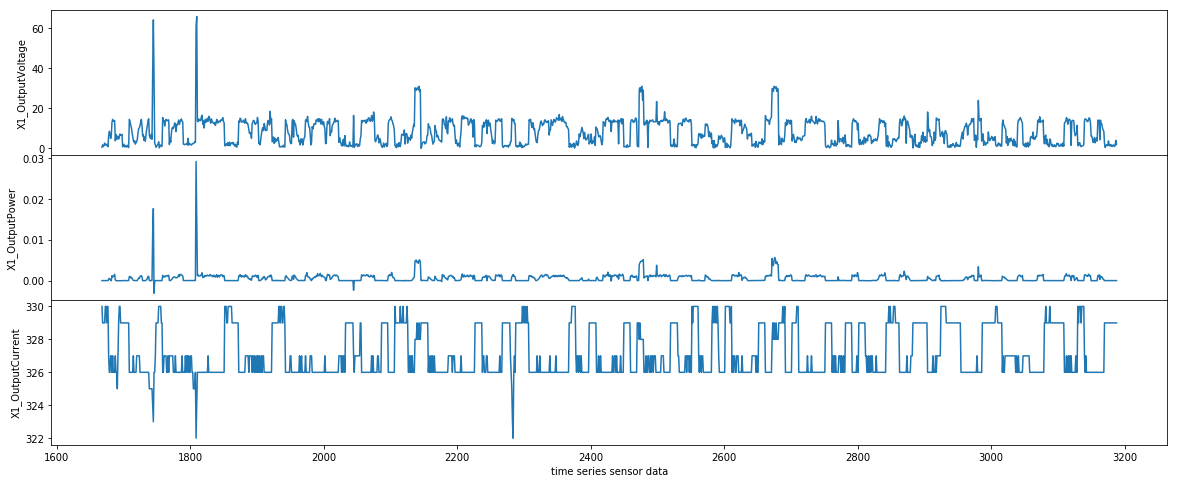

In [0]:
def plot_behavior_of_selected_features(experiment_no, features):
  experiment_df = train_df[train_df['exp_no'] == experiment_no]
  
  
  fig, axes = plt.subplots(len(features), 1,
                           sharex=True, figsize = (20, 8))
  index = 0
  for feature in features:
    axes[index].plot(experiment_df[feature])
    axes[index].set_ylabel(feature)
    axes[index].set_xlabel('time series sensor data')
    index += 1
 
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()
  
# call func. plot!
plot_behavior_of_selected_features(3, ['X1_OutputVoltage', 'X1_OutputPower', 
                                       'X1_OutputCurrent'])

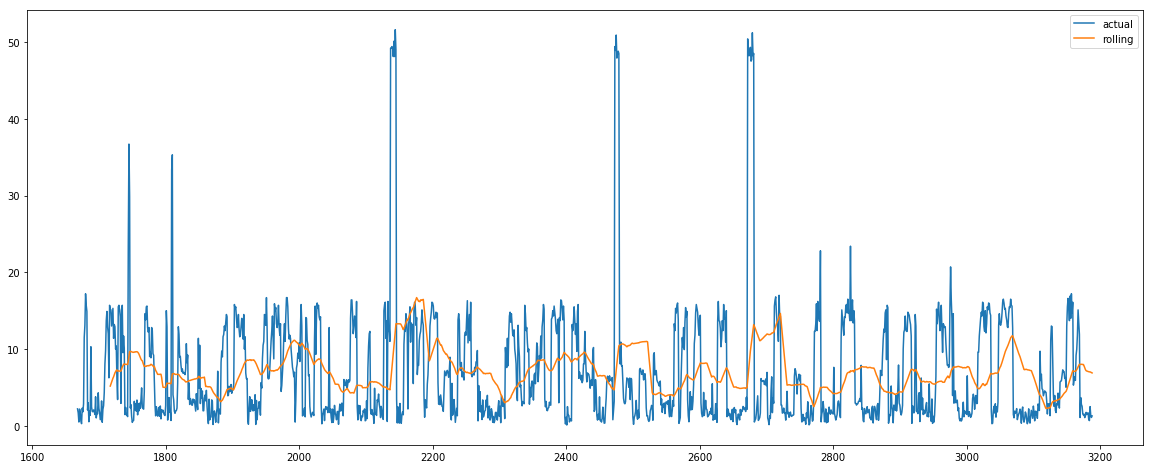

In [0]:
def plot_smoothing_sensor_values(experiment_no, feature, num_of_window):
  experiment_df = train_df[train_df['exp_no'] == experiment_no]
  
  plt.figure(figsize=(20, 8))
  experiment_df[feature].plot()
  experiment_df[feature].rolling(window=num_of_window).mean().plot()
  plt.legend(['actual', 'rolling'])
  plt.show()

# call func. plot!
plot_smoothing_sensor_values(3, 'Y1_OutputVoltage', 50)

# 4. `Feature Extraction`


```
Extract features from sensor values.
Each experiment is time series data. Sensor values is noisy. Therefore, sensor data will be smoothing!
Rolling mean and standard deviation have used for smooth sensor values with specified window size!
```



In [0]:
# create new feature name
# for example: X1_ActualVelocity_AV

def replace_string(data, added):
  return data + "_" + added

*** 4.1 Create 'Standard Deviation' and 'Mean' Rolling Feature From Each Sensor Data
with Specified Window Size***

In [0]:
# create mean and standard deviation features from sensor data
# 1. select sensor data 
# 2. create new feature names(eg: X1_ActualVelocity_AV, X1_ActualVelocity_SD)
# 3. Use rolling to find mean and standard deviation for features of 
# each experiment! Because, each experiment is separately time series data.


def create_new_features(df_in, rolling_win_size, sensor_features):
    
  sensor_av_features = [replace_string(feature, 'AV') for feature 
                        in sensor_features]
  sensor_sd_features = [replace_string(feature, 'SD') for feature 
                        in sensor_features]
    
  df_out = pd.DataFrame()
    
  ws = rolling_win_size
    
  for exp_id in pd.unique(df_in.exp_no):
    
      # get each experiment with selected sensor data
      df_experiment = df_in[df_in['exp_no'] == exp_id]
      df_sub = df_experiment[sensor_features]

    
      # get rolling mean from selected experiment
      av = df_sub.rolling(ws, min_periods=1).mean()
      av.columns = sensor_av_features
        
      #  get rolling std from selected experiment
      sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
      sd.columns = sensor_sd_features
    
      # combine new features and experiment df
      new_ftrs = pd.concat([df_experiment, av, sd], axis=1)
    
      # add the new features rows to the output dataframe
      df_out = pd.concat([df_out, new_ftrs])
        
  return df_out

In [0]:
# create new features of training dataset

window_size = 30

train_df = create_new_features(train_df, window_size, high_corr_features)
train_df.head()

,X1_ActualVelocity,X1_ActualAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualVelocity,Y1_DCBusVoltage,Y1_OutputCurrent,...,S1_OutputVoltage_SD,X1_ActualAcceleration_SD,X1_ActualVelocity_SD,Z1_ActualVelocity_SD,S1_ActualAcceleration_SD,Y1_ActualVelocity_SD,X1_CurrentFeedback_SD,S1_OutputCurrent_SD,X1_OutputCurrent_SD,Y1_OutputCurrent_SD
0,0.0,0.0,-0.284,2.790000e-19,329.0,0.0,0.000000e+00,0.0,2.680000e-19,333.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,-0.284,2.790000e-19,329.0,0.0,0.000000e+00,0.0,2.680000e-19,333.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,1.170,2.780000e-19,325.0,0.0,9.160000e-07,0.0,2.690000e-19,327.0,...,0.0,0.0,0.0,0.000000,0.108542,0.0,0.839467,4.618802,2.309401,3.464102
3,0.0,0.0,-0.230,2.790000e-19,329.0,0.0,-2.300000e-07,0.0,2.680000e-19,333.0,...,0.0,0.0,0.0,0.012500,0.294485,0.0,0.718451,4.000000,2.000000,3.000000
4,0.0,0.0,-0.230,2.790000e-19,329.0,0.0,-2.300000e-07,0.0,2.680000e-19,333.0,...,0.0,0.0,0.0,0.013693,0.317067,0.0,0.638745,3.577709,1.788854,2.683282


In [0]:
# create new features of tes dataset

test_df = create_new_features(test_df, window_size, high_corr_features)
test_df.head()

,X1_ActualVelocity,X1_ActualAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualVelocity,Y1_DCBusVoltage,Y1_OutputCurrent,...,S1_OutputVoltage_SD,X1_ActualAcceleration_SD,X1_ActualVelocity_SD,Z1_ActualVelocity_SD,S1_ActualAcceleration_SD,Y1_ActualVelocity_SD,X1_CurrentFeedback_SD,S1_OutputCurrent_SD,X1_OutputCurrent_SD,Y1_OutputCurrent_SD
0,0.0,0.00,0.18,0.0207,329.0,2.77,-0.000001,-0.025,0.0167,328.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-10.8,-350.00,-10.90,0.1860,328.0,23.30,0.004480,-19.800,0.2810,325.0,...,0.0,247.487373,7.636753,14.354268,0.000000,13.983037,7.834743,0.707107,0.707107,2.121320
2,-17.8,-6.25,-8.59,0.1400,328.0,30.60,0.005330,-32.500,0.1390,327.0,...,0.0,200.292754,8.967348,16.967322,0.397217,16.365443,5.845446,0.577350,0.577350,1.527525
3,-18.0,0.00,-6.11,0.1300,327.0,30.30,0.004890,-32.600,0.1560,325.0,...,0.0,173.983282,8.457541,15.923227,0.351429,15.362147,4.775580,0.500000,0.816497,1.500000
4,-17.9,-18.80,-5.70,0.1140,328.0,30.50,0.004250,-32.000,0.2020,326.0,...,0.0,153.915563,7.839643,14.745270,0.310811,14.148847,4.146134,0.447214,0.707107,1.303840


# 5. `Classification`



```
Extract features from sensor values.
Each experiment is time series data. Sensor values is noisy. Therefore, sensor data will be smoothing!
Rolling mean and standard deviation have used for smooth sensor values with specified window size!
```



*** 5.1 Prepare (train_x, train_y), (test_x, test_y) ***

In [0]:
features = ['X1_ActualVelocity', 'X1_ActualAcceleration', 'X1_CurrentFeedback',
       'X1_DCBusVoltage', 'X1_OutputCurrent', 'X1_OutputVoltage',
       'X1_OutputPower', 'Y1_ActualVelocity', 'Y1_DCBusVoltage',
       'Y1_OutputCurrent', 'Y1_OutputVoltage', 'Y1_OutputPower',
       'Z1_ActualVelocity', 'S1_ActualVelocity', 'S1_ActualAcceleration',
       'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage',
       'S1_OutputPower', 'M1_CURRENT_FEEDRATE',
       'X1_DCBusVoltage_AV', 'X1_OutputVoltage_AV', 'Y1_OutputVoltage_AV',
       'X1_OutputPower_AV', 'Y1_OutputPower_AV', 'Y1_DCBusVoltage_AV',
       'M1_CURRENT_FEEDRATE_AV', 'S1_DCBusVoltage_AV',
       'S1_ActualVelocity_AV', 'S1_OutputPower_AV', 'S1_OutputVoltage_AV',
       'X1_ActualAcceleration_AV', 'X1_ActualVelocity_AV',
       'Z1_ActualVelocity_AV', 'S1_ActualAcceleration_AV',
       'Y1_ActualVelocity_AV', 'X1_CurrentFeedback_AV',
       'S1_OutputCurrent_AV', 'X1_OutputCurrent_AV',
       'Y1_OutputCurrent_AV', 'X1_DCBusVoltage_SD', 'X1_OutputVoltage_SD',
       'Y1_OutputVoltage_SD', 'X1_OutputPower_SD', 'Y1_OutputPower_SD',
       'Y1_DCBusVoltage_SD', 'M1_CURRENT_FEEDRATE_SD',
       'S1_DCBusVoltage_SD', 'S1_ActualVelocity_SD', 'S1_OutputPower_SD',
       'S1_OutputVoltage_SD', 'X1_ActualAcceleration_SD',
       'X1_ActualVelocity_SD', 'Z1_ActualVelocity_SD',
       'S1_ActualAcceleration_SD', 'Y1_ActualVelocity_SD',
       'X1_CurrentFeedback_SD', 'S1_OutputCurrent_SD',
       'X1_OutputCurrent_SD', 'Y1_OutputCurrent_SD']

In [0]:
# prepare train_x and train_y

train_x = train_df[features]
train_y = train_df['target']

print("train_x shape: {}".format(train_x.shape))

train_x shape: (21254, 60)


In [0]:
# prepare train_x and train_y

test_x = test_df[features]
test_y = test_df['target']

print("test_x shape: {}".format(test_x.shape))

test_x shape: (4032, 60)


*** 5.2 Compare Classifiers ***

In [0]:
# pass model and its parameters
# find best model using these parameters 
# with 'roc_auc'.


def classify_with_best_model(clf, 
                 train_x, train_y, 
                 test_x, _test_y, 
                 params=None, score=None):
  
  
    # pass model, its parameters, cross validation value,
    # score(roc_auc) for compare algorithms
    grid_search = model_selection.GridSearchCV(estimator=clf, 
                                               param_grid=params,
                                               cv=5, 
                                               scoring=score, 
                                               n_jobs=-1)

    # train model and predict test dataset
    grid_search.fit(train_x, train_y)
    y_pred = grid_search.predict(test_x)
    
    # get predict score
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(test_x)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(test_x)
    else:
        y_score = y_pred
        
    # covert scores and predictions to dataframe 
    # for use later 
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    # return best model and its predictions and scores
    return grid_search.best_estimator_, df_predictions

In [0]:
# find confusion matrix and roc curve
# for convusion matrix;
#              In binary classification, the count of 
#              true negatives is C00,
#              false negatives is C10,
#              true positives is C11, 
#              false positives is C01.


def get_classification_metrics(algorihm_name, y_test, y_pred, y_score,
                               print_out=True, plot_out=True):
  
    classification_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(classification_metrics, orient='index')
    df_metrics.columns = [algorihm_name]  

    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)
    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test,
                                                                   y_score)

    if print_out:
        print('-----------------------------------------------------------')
        print(algorihm_name, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

    if plot_out:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False,
                                       sharey=False )
        fig.set_size_inches(20,8)
        ax1.plot(fpr, tpr, color='darkorange', lw=2,
                 label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2,
                 label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

    return  df_metrics


Best Parameters:
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[ 889 1160]
 [ 227 1756]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.43      0.56      2049
           1       0.60      0.89      0.72      1983

   micro avg       0.66      0.66      0.66      4032
   macro avg       0.70      0.66      0.64      4032
weighted avg       0.70      0.66      0.64      4032


Metrics:
           Logistic Regression
Accuracy              0.656002
Precision             0.602195
Recall                0.885527
F1 Score              0.716881
ROC AUC               0.706638


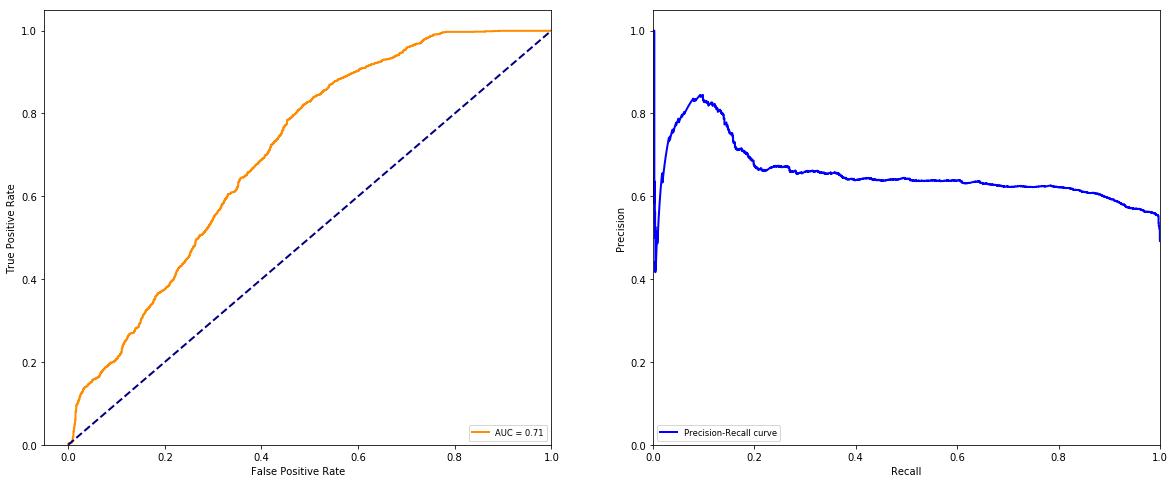

In [0]:
algorihm_name = 'Logistic Regression'
model_lr = LogisticRegression(random_state=123)
params = {
    'C': [.01, 0.1, 1.0, 10], 
    'solver': ['liblinear', 'lbfgs']
}
score = 'roc_auc'

model_lr, pred_model_lr = classify_with_best_model(model_lr,
                                                   train_x, train_y,
                                                   test_x, test_y, 
                                                   params=params, 
                                                   score=score)
print('\nBest Parameters:\n', model_lr)

metrics_lr = get_classification_metrics(algorihm_name, test_y,
                                        pred_model_lr.y_pred,
                                        pred_model_lr.y_score,
                                        print_out=True,
                                        plot_out=True)


Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')
-----------------------------------------------------------
Decision Tree 

Confusion Matrix:
[[1098  951]
 [1482  501]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.54      0.47      2049
           1       0.35      0.25      0.29      1983

   micro avg       0.40      0.40      0.40      4032
   macro avg       0.39      0.39      0.38      4032
weighted avg       0.39      0.40      0.38      4032


Metrics:
           Decision Tree
Accuracy        0.396577
Precision       0.345041
Recall          0.252648
F1 Score        0.291703
ROC AUC         0.407394


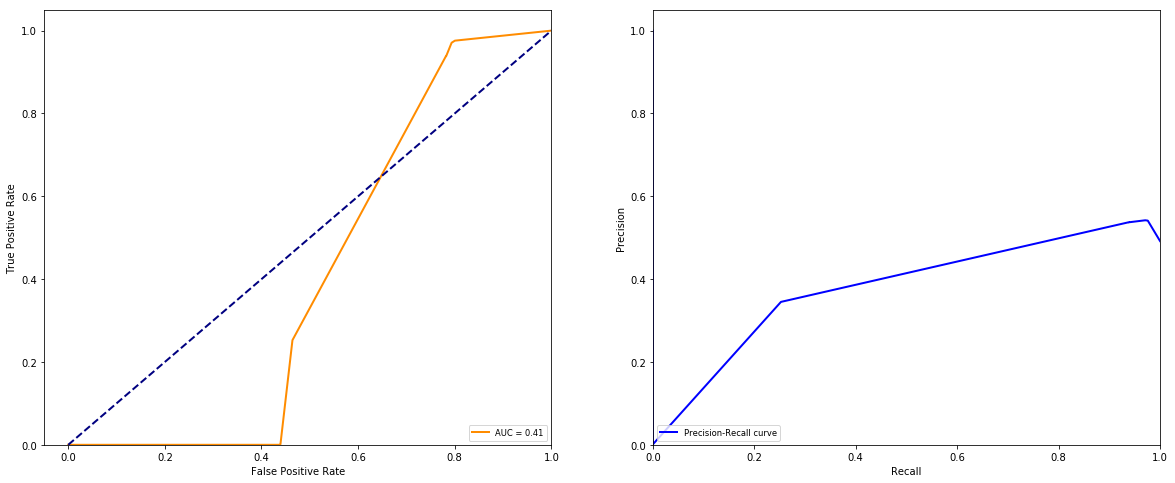

In [0]:
algorihm_name = 'Decision Tree'
model_dt = DecisionTreeClassifier(random_state=123)
params = {
    'max_depth': [1, 5, 10, 20, 30, 40, 50, 100],
    'criterion': ['gini', 'entropy']
}
score = 'roc_auc'

model_dt, pred_model_dt = classify_with_best_model(model_dt,
                                                   train_x, train_y,
                                                   test_x, test_y, 
                                                   params=params, 
                                                   score=score)
print('\nBest Parameters:\n', model_dt)

metrics_dt = get_classification_metrics(algorihm_name, test_y,
                                        pred_model_dt.y_pred,
                                        pred_model_dt.y_score,
                                        print_out=True,
                                        plot_out=True)


Best Parameters:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
-----------------------------------------------------------
XGBClassifier 

Confusion Matrix:
[[1337  712]
 [1276  707]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.65      0.57      2049
           1       0.50      0.36      0.42      1983

   micro avg       0.51      0.51      0.51      4032
   macro avg       0.50      0.50      0.49      4032
weighted avg       0.51      0.51      0.50      4032


Metrics:
           XGBClassifier
Accuracy        0.506944
Precision       0.498238
Recall          0.356531
F1 Score   

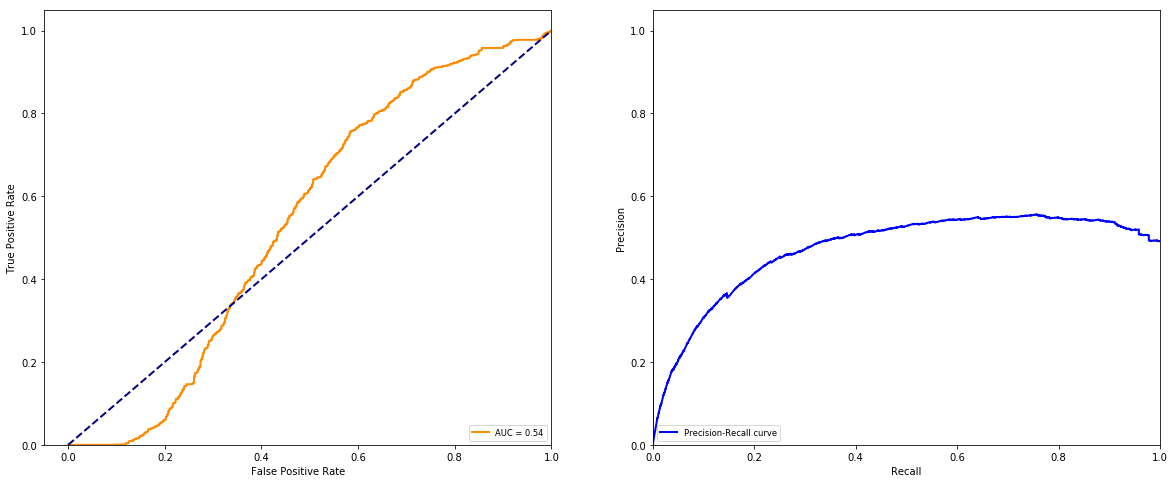

In [0]:
from xgboost import XGBClassifier

algorihm_name = 'XGBClassifier'
model_xgb = XGBClassifier()
params = {}
score = 'roc_auc'

model_xgb, pred_model_xgb = classify_with_best_model(model_xgb,
                                                     train_x, train_y,
                                                     test_x, test_y, 
                                                     params=params, 
                                                     score=score)
print('\nBest Parameters:\n', model_xgb)

metrics_xgb = get_classification_metrics(algorihm_name, test_y,
                                         pred_model_xgb.y_pred,
                                         pred_model_xgb.y_score,
                                         print_out=True,
                                         plot_out=True)


Best Parameters:
 GaussianNB(priors=None, var_smoothing=1e-09)
-----------------------------------------------------------
Gaussian 

Confusion Matrix:
[[ 603 1446]
 [1262  721]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.29      0.31      2049
           1       0.33      0.36      0.35      1983

   micro avg       0.33      0.33      0.33      4032
   macro avg       0.33      0.33      0.33      4032
weighted avg       0.33      0.33      0.33      4032


Metrics:
           Gaussian
Accuracy   0.328373
Precision  0.332718
Recall     0.363591
F1 Score   0.347470
ROC AUC    0.382110


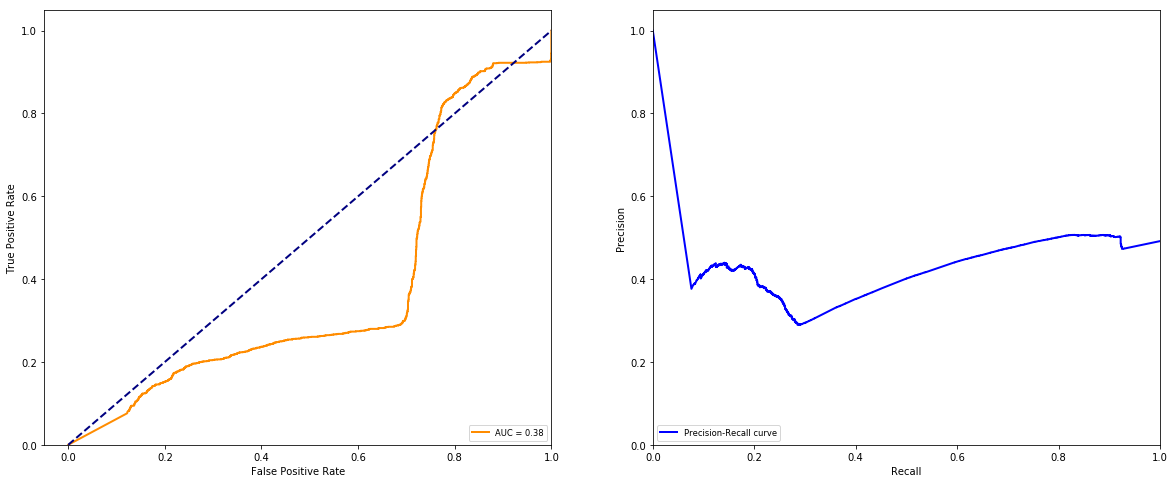

In [0]:
algorihm_name = 'Gaussian'
model_gaus = GaussianNB()
params = {} 
score = 'roc_auc'

model_gaus, pred_model_gaus = classify_with_best_model(model_gaus,
                                                       train_x, train_y,
                                                       test_x, test_y, 
                                                       params=params, 
                                                       score=score)
print('\nBest Parameters:\n', model_gaus)

metrics_gaus = get_classification_metrics(algorihm_name, test_y,
                                          pred_model_gaus.y_pred,
                                          pred_model_gaus.y_score,
                                          print_out=True,
                                          plot_out=True)


Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
-----------------------------------------------------------
KNN 

Confusion Matrix:
[[1128  921]
 [1116  867]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.55      0.53      2049
           1       0.48      0.44      0.46      1983

   micro avg       0.49      0.49      0.49      4032
   macro avg       0.49      0.49      0.49      4032
weighted avg       0.49      0.49      0.49      4032


Metrics:
                KNN
Accuracy   0.494792
Precision  0.484899
Recall     0.437216
F1 Score   0.459825
ROC AUC    0.507195


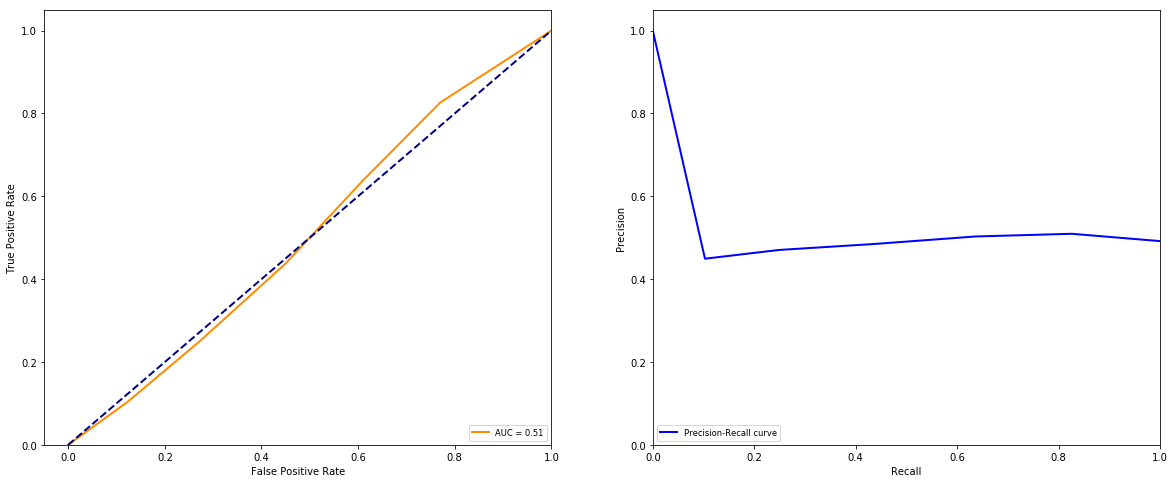

In [0]:
algorihm_name = 'KNN'
model_knn = KNeighborsClassifier(n_jobs=-1)
params = {
    'n_neighbors': [1, 2, 3, 5, 10],
    'metric': ['euclidean', 'manhattan']
}
score = 'roc_auc'

model_knn, pred_model_knn = classify_with_best_model(model_knn,
                                                     train_x, train_y,
                                                     test_x, test_y, 
                                                     params=params, 
                                                     score=score)
print('\nBest Parameters:\n', model_knn)

metrics_knn = get_classification_metrics(algorihm_name, test_y,
                                          pred_model_knn.y_pred,
                                          pred_model_knn.y_score,
                                          print_out=True,
                                          plot_out=True)

In [0]:
all_classify_metrics = pd.concat([metrics_lr, metrics_dt, metrics_gaus,  
                                  metrics_xgb, metrics_knn], axis=1)
all_classify_metrics

,Logistic Regression,Decision Tree,Gaussian,XGBClassifier,KNN
Accuracy,0.656002,0.396577,0.328373,0.506944,0.494792
Precision,0.602195,0.345041,0.332718,0.498238,0.484899
Recall,0.885527,0.252648,0.363591,0.356531,0.437216
F1 Score,0.716881,0.291703,0.347470,0.415638,0.459825
ROC AUC,0.706638,0.407394,0.382110,0.539351,0.507195
